# Movie Review Sentiment Analysis

This notebook demonstrates sentiment analysis on IMDB movie reviews.

In [1]:
import sys
sys.path.append('..')

from src.preprocessing.cleaner import TextCleaner
from src.features.vectorizer import TextVectorizer
from src.models.classifier import TextClassifier
from src.models.model_evaluation import evaluate_model, plot_confusion_matrix
from src.data.load_data import download_movie_reviews

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np

In [2]:
# Load the dataset
print("Loading dataset...")
df = download_movie_reviews()

print(f"Dataset size: {len(df)} reviews")
print(f"Positive reviews: {sum(df['label'])}")
print(f"Negative reviews: {len(df) - sum(df['label'])}")

# Let's look at a few examples
print("\nExample reviews:")
for i, (text, label) in df.iloc[:3].iterrows():
    sentiment = "Positive" if label == 1 else "Negative"
    print(f"\nReview {i+1} ({sentiment}):")
    print(text[:200], "...")  # Print first 200 characters

Loading dataset...
Loading IMDB Movie Reviews dataset...
Dataset size: 50000 reviews
Positive reviews: 25000
Negative reviews: 25000

Example reviews:

Review 1 (Positive):
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and no ...

Review 2 (Negative):
? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ...

Review 3 (Negative):
? this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touchi ...


In [3]:
# Clean and vectorize texts
cleaner = TextCleaner()
cleaned_texts = cleaner.clean_text(df['text'].tolist())

# Look at the difference
print("Original vs Cleaned text example:")
print("\nORIGINAL:")
print(df['text'][0][:200])
print("\nCLEANED:")
print(cleaned_texts[0][:200])

# Vectorize
vectorizer = TextVectorizer(
    vectorizer_type='tfidf',
    max_features=10000,
    min_df=2,
    max_df=0.95
)
X = vectorizer.fit_transform(cleaned_texts)
print(f"\nFeature matrix shape: {X.shape}")

[nltk_data] Downloading package punkt to /Users/benisrael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/benisrael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/benisrael/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original vs Cleaned text example:

ORIGINAL:
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and no

CLEANED:
this film was just brilliant casting location scenery story direction everyone s really suited the part they played and you could just imagine being there robert redford s is an amazing actor and now 

Feature matrix shape: (50000, 10000)


Training set size: 40000
Test set size: 10000

Classification Report:
{'0': {'precision': 0.8985714285714286, 'recall': 0.8806, 'f1-score': 0.8894949494949494, 'support': 5000.0}, '1': {'precision': 0.8829411764705882, 'recall': 0.9006, 'f1-score': 0.8916831683168317, 'support': 5000.0}, 'accuracy': 0.8906, 'macro avg': {'precision': 0.8907563025210083, 'recall': 0.8906000000000001, 'f1-score': 0.8905890589058906, 'support': 10000.0}, 'weighted avg': {'precision': 0.8907563025210086, 'recall': 0.8906, 'f1-score': 0.8905890589058905, 'support': 10000.0}}


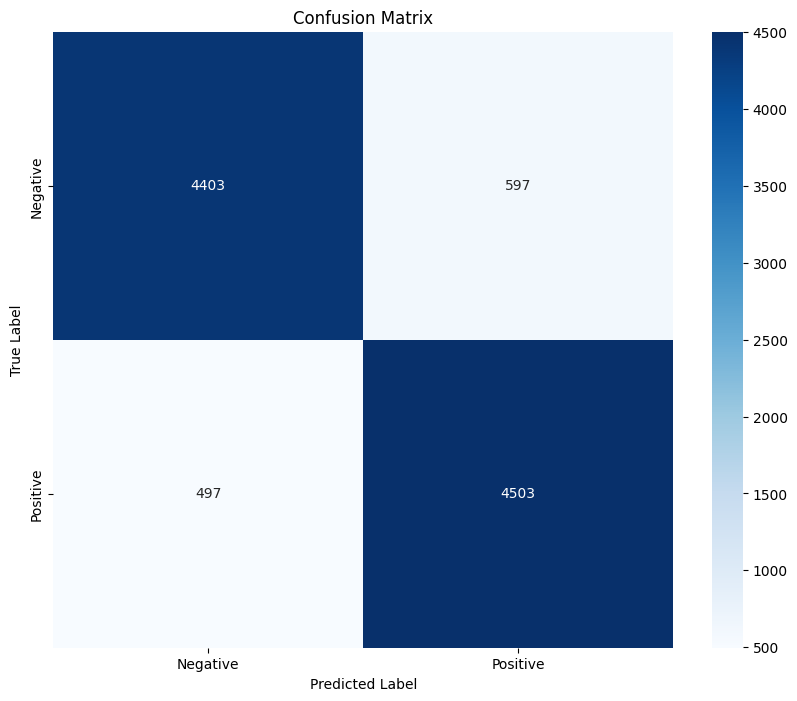

In [4]:
# Split and train
X_train, X_test, y_train, y_test = train_test_split(
    X, df['label'], 
    test_size=0.2, 
    random_state=42,
    stratify=df['label']  # Ensure balanced split
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Train classifier
classifier = TextClassifier(LogisticRegression(
    max_iter=1000,
    C=1.0,
    class_weight='balanced'
))
classifier.train(X_train, y_train)

# Evaluate
y_pred = classifier.predict(X_test)
metrics = evaluate_model(y_test, y_pred)
print("\nClassification Report:")
print(metrics['classification_report'])

# Plot confusion matrix
plot_confusion_matrix(
    metrics['confusion_matrix'],
    labels=['Negative', 'Positive']
)

In [22]:
# Test with your own reviews
test_reviews = [
    "This movie was absolutely fantastic! Great acting and storyline.",
    "Terrible waste of time. Poor acting and boring plot.",
    "It was okay, not great but not terrible either.",
    # Add your own reviews here!
    "The special effects were amazing but the plot made no sense.",
    "I've never been so bored in my life. Complete waste of money.",
    "While not perfect, the film's strong performances make it worth watching.",
    "This movie was okay and I would watch it again."
]

# Process and predict
cleaned_examples = cleaner.clean_text(test_reviews)
X_examples = vectorizer.transform(cleaned_examples)
predictions = classifier.predict(X_examples)

# Show results
for review, pred in zip(test_reviews, predictions):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"\nReview: {review}")
    print(f"Predicted sentiment: {sentiment}")


Review: This movie was absolutely fantastic! Great acting and storyline.
Predicted sentiment: Positive

Review: Terrible waste of time. Poor acting and boring plot.
Predicted sentiment: Negative

Review: It was okay, not great but not terrible either.
Predicted sentiment: Negative

Review: The special effects were amazing but the plot made no sense.
Predicted sentiment: Positive

Review: I've never been so bored in my life. Complete waste of money.
Predicted sentiment: Negative

Review: While not perfect, the film's strong performances make it worth watching.
Predicted sentiment: Positive

Review: This movie was okay and I would watch it again.
Predicted sentiment: Negative


In [69]:
# First, let's look at some actual reviews from our test set
print("ACTUAL REVIEWS FROM DATASET:")
for i in range(5):  # Look at 5 examples
    review_text = df['text'][i]
    true_label = df['label'][i]
    
    # Get model's prediction for this review
    cleaned_review = cleaner.clean_text(review_text)
    X_review = vectorizer.transform([cleaned_review])
    predicted_label = classifier.predict(X_review)[0]
    
    print(f"\nReview {i+1}:")
    print(f"Text: {review_text[:200]}...")  # First 200 characters
    print(f"True Sentiment: {'Positive' if true_label == 1 else 'Negative'}")
    print(f"Predicted Sentiment: {'Positive' if predicted_label == 1 else 'Negative'}")
    print(f"Correct? {'✓' if true_label == predicted_label else '✗'}")

# Now compare with our custom examples
print("\nCUSTOM REVIEW EXAMPLES:")
test_reviews = [
    "This movie was absolutely fantastic! Great acting and storyline.",
    "Terrible waste of time. Poor acting and boring plot.",
    "It was okay, not great but not terrible either."
]

cleaned_examples = cleaner.clean_text(test_reviews)
X_examples = vectorizer.transform(cleaned_examples)
predictions = classifier.predict(X_examples)

for review, pred in zip(test_reviews, predictions):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"\nReview: {review}")
    print(f"Predicted sentiment: {sentiment}")

ACTUAL REVIEWS FROM DATASET:

Review 1:
Text: ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and no...
True Sentiment: Positive
Predicted Sentiment: Positive
Correct? ✓

Review 2:
Text: ? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst...
True Sentiment: Negative
Predicted Sentiment: Negative
Correct? ✓

Review 3:
Text: ? this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touchi...
True Sentiment: Negative
Predicted Sentiment: Negative
Correct? ✓

Review 4:
Text: ? the scots excel at storytelling the traditional sort many years after the event i can still

In [70]:
# Let's look at some misclassified examples
print("\nMISCLASSIFIED EXAMPLES:")
y_pred_test = classifier.predict(X_test)
misclassified_indices = np.where(y_test.values != y_pred_test)[0]

for i in misclassified_indices[:5]:  # Look at first 5 misclassified examples
    # Get the actual index from the test set
    test_indices = y_test.index[i]
    review_text = df['text'][test_indices]
    true_label = y_test.iloc[i]
    pred_label = y_pred_test[i]
    
    print(f"\nReview:")
    print(f"Text: {review_text[:200]}...")
    print(f"True Sentiment: {'Positive' if true_label == 1 else 'Negative'}")
    print(f"Predicted (Incorrectly): {'Positive' if pred_label == 1 else 'Negative'}")


MISCLASSIFIED EXAMPLES:

Review:
Text: ? honestly i am not that impressed by it it's not a bad movie but it's not great one either there's a story to tell but it's told in a very incoherent way which kinds of makes it loose it's full meani...
True Sentiment: Negative
Predicted (Incorrectly): Positive

Review:
Text: ? since this show was changed from the screen to attack of the show it has gone down hill with yoshi and kevin rose alex etc made the show awesome then they got fired from for an unknown reason when t...
True Sentiment: Negative
Predicted (Incorrectly): Positive

Review:
Text: ? i'm not going to say the story of the movie as some people do i'm pretty sure people who read this will know what the storyline is i'm also not going to go on and on about everything thats wrong wit...
True Sentiment: Negative
Predicted (Incorrectly): Positive

Review:
Text: ? full disclosure i'm a cynic i like my endings sad and my hankies dry i didn't cry when bambi's mother was shot will smith's 

In [71]:
# Add this to your notebook to explore the data
print("Dataset Overview:")
print(f"Total reviews: {len(df)}")
print("\nDataframe columns:", df.columns.tolist())
print("\nSample size of each class:")
print(df['label'].value_counts())

# Look at a few complete reviews
print("\nComplete Review Examples:")
for i in range(3):
    print(f"\n--- Review {i+1} ---")
    print(f"Sentiment: {'Positive' if df['label'].iloc[i] == 1 else 'Negative'}")
    print(f"Full text:\n{df['text'].iloc[i]}")

Dataset Overview:
Total reviews: 50000

Dataframe columns: ['text', 'label']

Sample size of each class:
label
1    25000
0    25000
Name: count, dtype: int64

Complete Review Examples:

--- Review 1 ---
Sentiment: Positive
Full text:
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part'

In [ ]:
from src.features.dimensionality_reducer import DimensionalityReducer
import matplotlib.pyplot as plt
import seaborn as sns

# After vectorizing your text
X = vectorizer.fit_transform(cleaned_texts)

# Try different reduction methods
methods = ['pca', 'tsne', 'umap']
plt.figure(figsize=(15, 5))

for i, method in enumerate(methods, 1):
    plt.subplot(1, 3, i)
    reducer = DimensionalityReducer(method=method)
    X_reduced = reducer.fit_transform(X)
    
    # Create scatter plot
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], 
                         c=df['label'],
                         cmap='RdYlBu',  # Red for negative, Blue for positive
                         alpha=0.5,       # Transparency
                         s=10)            # Point size
    
    plt.title(f'{method.upper()} Visualization')
    plt.colorbar(scatter, label='Sentiment')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nVisualization Analysis:")
print("- Each point represents one movie review")
print("- Blue points are positive reviews")
print("- Red points are negative reviews")
print(f"- Total reviews plotted: {len(df)}")